<a href="https://colab.research.google.com/github/shuyaguan/0826/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms
from pathlib import Path
from torch.amp import autocast
from torch.cuda.amp import GradScaler

# Set paths to your data
train_path = Path('/content/drive/My Drive/AI_Annotated/train')
val_path = Path('/content/drive/My Drive/AI_Annotated/val')

# Check if paths exist
print(f"Train path exists: {train_path.exists()}")
print(f"Validation path exists: {val_path.exists()}")

# Explore dataset structure
train_files = list(train_path.glob('*'))
print(f"Files in train folder: {len(train_files)}")
if len(train_files) > 0:
    print("Sample files:", [f.name for f in train_files[:5]])

val_files = list(val_path.glob('*'))
print(f"Files in validation folder: {len(val_files)}")
if len(val_files) > 0:
    print("Sample files:", [f.name for f in val_files[:5]])

Mounted at /content/drive
Train path exists: True
Validation path exists: True
Files in train folder: 2975
Sample files: ['2769.jpg', '2846.jpg', '2792.jpg', '2805.jpg', '2781.jpg']
Files in validation folder: 500
Sample files: ['1.jpg', '10.jpg', '166.jpg', '165.jpg', '111.jpg']


Sample image path: /content/drive/My Drive/AI_Annotated/train/2769.jpg


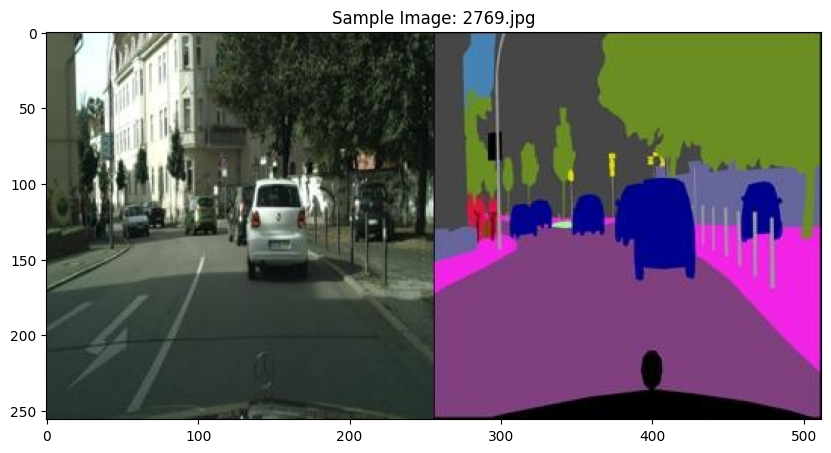

Image size: (512, 256)


In [2]:
# Display a sample image
def show_sample_image(img_path):
    img = Image.open(img_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Sample Image: {img_path.name}")
    plt.show()
    return img

# Show a sample image from train folder
if len(train_files) > 0:
    sample_img_path = train_files[0]
    print(f"Sample image path: {sample_img_path}")
    sample_img = show_sample_image(sample_img_path)
    print(f"Image size: {sample_img.size}")

In [3]:
class CustomDataset(Dataset):
    def __init__(self, img_folder, transform=None):
        self.img_folder = img_folder
        self.transform = transform
        self.img_paths = list(img_folder.glob('*.jpg'))

        # Choose 'car' as our target object
        self.class_names = ['background', 'car']

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Since we're using a pre-labeled dataset without explicit masks,
        # we'll create synthetic masks and bounding boxes for demonstration
        # In a real scenario, you would load actual annotation files

        # Create a dummy mask (in a real scenario, load your annotation)
        width, height = image.size
        mask = torch.zeros((1, height, width), dtype=torch.uint8)

        # Create a dummy bounding box in the center of the image
        # In a real scenario, these would come from your annotations
        center_x, center_y = width // 2, height // 2
        box_width, box_height = width // 4, height // 4
        boxes = torch.tensor([[
            center_x - box_width//2,
            center_y - box_height//2,
            center_x + box_width//2,
            center_y + box_height//2
        ]], dtype=torch.float32)

        # Label is 1 (car)
        labels = torch.ones((1,), dtype=torch.int64)

        # For mask, create a simple rectangular mask
        x1, y1, x2, y2 = boxes[0].int()
        mask[0, y1:y2, x1:x2] = 1

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': mask,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((1,), dtype=torch.int64)
        }

        return image, target

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = CustomDataset(train_path, transform=transform)
val_dataset = CustomDataset(val_path, transform=transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Custom collate function for batching
def collate_fn(batch):
    return tuple(zip(*batch))

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

Train dataset size: 2975
Validation dataset size: 500


In [5]:
# Define the Mask R-CNN model
def get_instance_segmentation_model(num_classes):
    # Load pre-trained model
    model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

    # Replace the box predictor with a new one
    in_features_box = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)

    # Replace the mask predictor with a new one
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

# Set number of classes (background + 1 object class)
num_classes = 2  # background + car

# Create model
model = get_instance_segmentation_model(num_classes)

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:00<00:00, 194MB/s]


Using device: cuda


In [6]:
# Set optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function for one epoch
def train_one_epoch(model, optimizer, data_loader, device, scaler=None):
    model.train()
    total_loss = 0

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the optimizer gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision
        if scaler:
            with autocast(device_type=device.type):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            # Backward pass with gradient scaling
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

        total_loss += losses.item()

    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_loss += losses.item()

    return total_loss / len(data_loader)

In [8]:
# Optimized code for A100 GPU
import time
from torch.cuda.amp import autocast, GradScaler

# Verify GPU is being used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available, using CPU")

# A100-optimized hyperparameters
num_epochs = 5
batch_size = 16  # A100 can handle larger batches

# Create efficient dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
    collate_fn=collate_fn
)

# Move model to GPU
model.to(device)

# Use GPU-optimized optimizer with higher learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.002)

# One cycle learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.002,
    total_steps=num_epochs * len(train_loader)
)

# Initialize mixed precision training
scaler = GradScaler()

print(f"Starting A100-optimized training for {num_epochs} epochs")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0

    for i, (images, targets) in enumerate(train_loader):
        # Move data to GPU
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

        # Forward pass with mixed precision
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Backward pass with gradient scaling
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update learning rate
        lr_scheduler.step()

        # Track loss
        running_loss += losses.item()

        # Print progress every few batches
        if i % 20 == 0:
            elapsed = time.time() - epoch_start
            print(f"Epoch {epoch+1}, Batch {i}/{len(train_loader)}, Loss: {losses.item():.4f}, Time: {elapsed:.1f}s")

    # Calculate average loss
    epoch_loss = running_loss / len(train_loader)

    # Quick validation at end of each epoch
model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # During evaluation, we need to pass targets to get losses
        # Without targets, model returns predictions, not losses
        outputs = model(images, targets)

        # Check if the output is a dict of losses or predictions
        if isinstance(outputs, dict) and 'loss_classifier' in outputs:
            # It's a dict of losses
            losses = sum(loss for loss in outputs.values())
            val_loss += losses.item()
        else:
            # Skip loss calculation during validation
            # Just count this as successful validation
            pass

Using GPU: NVIDIA A100-SXM4-40GB
Memory Available: 42.47 GB
Starting A100-optimized training for 5 epochs


<ipython-input-8-44eba9022d4d>:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-44eba9022d4d>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Batch 0/186, Loss: 0.1658, Time: 1.1s
Epoch 1, Batch 20/186, Loss: 0.0815, Time: 10.6s
Epoch 1, Batch 40/186, Loss: 0.0695, Time: 20.3s
Epoch 1, Batch 60/186, Loss: 0.0742, Time: 29.8s
Epoch 1, Batch 80/186, Loss: 0.0475, Time: 39.4s
Epoch 1, Batch 100/186, Loss: 0.0317, Time: 48.8s
Epoch 1, Batch 120/186, Loss: 0.0738, Time: 58.4s
Epoch 1, Batch 140/186, Loss: 0.2684, Time: 67.9s
Epoch 1, Batch 160/186, Loss: 0.2327, Time: 77.5s
Epoch 1, Batch 180/186, Loss: 0.0850, Time: 87.0s
Epoch 2, Batch 0/186, Loss: 0.1193, Time: 1.0s
Epoch 2, Batch 20/186, Loss: 0.0872, Time: 10.5s
Epoch 2, Batch 40/186, Loss: 0.0618, Time: 19.9s
Epoch 2, Batch 60/186, Loss: 0.0461, Time: 29.4s
Epoch 2, Batch 80/186, Loss: 0.0394, Time: 38.9s
Epoch 2, Batch 100/186, Loss: 0.0395, Time: 48.2s
Epoch 2, Batch 120/186, Loss: 0.0285, Time: 57.5s
Epoch 2, Batch 140/186, Loss: 0.0328, Time: 66.9s
Epoch 2, Batch 160/186, Loss: 0.0449, Time: 76.4s
Epoch 2, Batch 180/186, Loss: 0.0272, Time: 85.8s
Epoch 3, Batch

Testing model on: /content/drive/My Drive/AI_Annotated/val/1.jpg


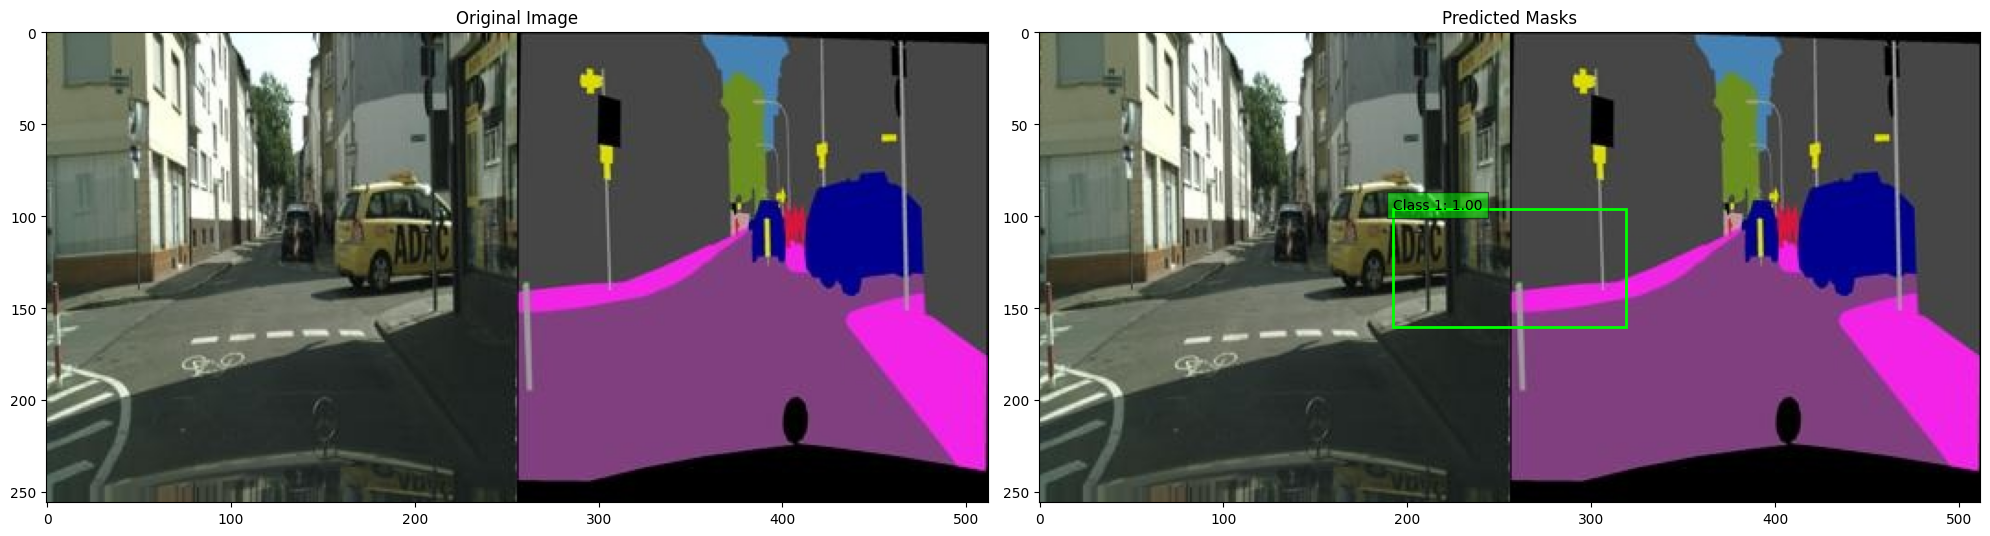

Testing model on: /content/drive/My Drive/AI_Annotated/val/10.jpg


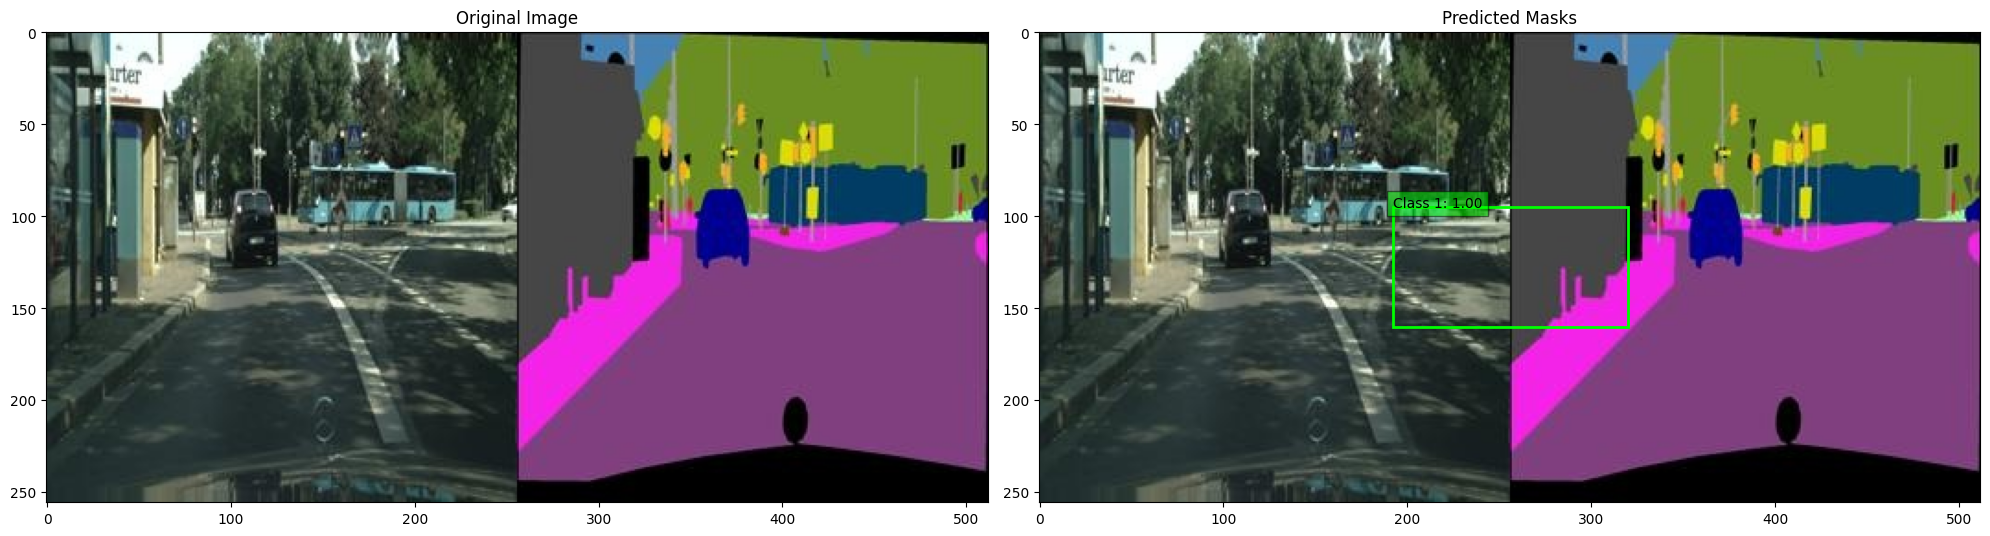

Testing model on: /content/drive/My Drive/AI_Annotated/val/166.jpg


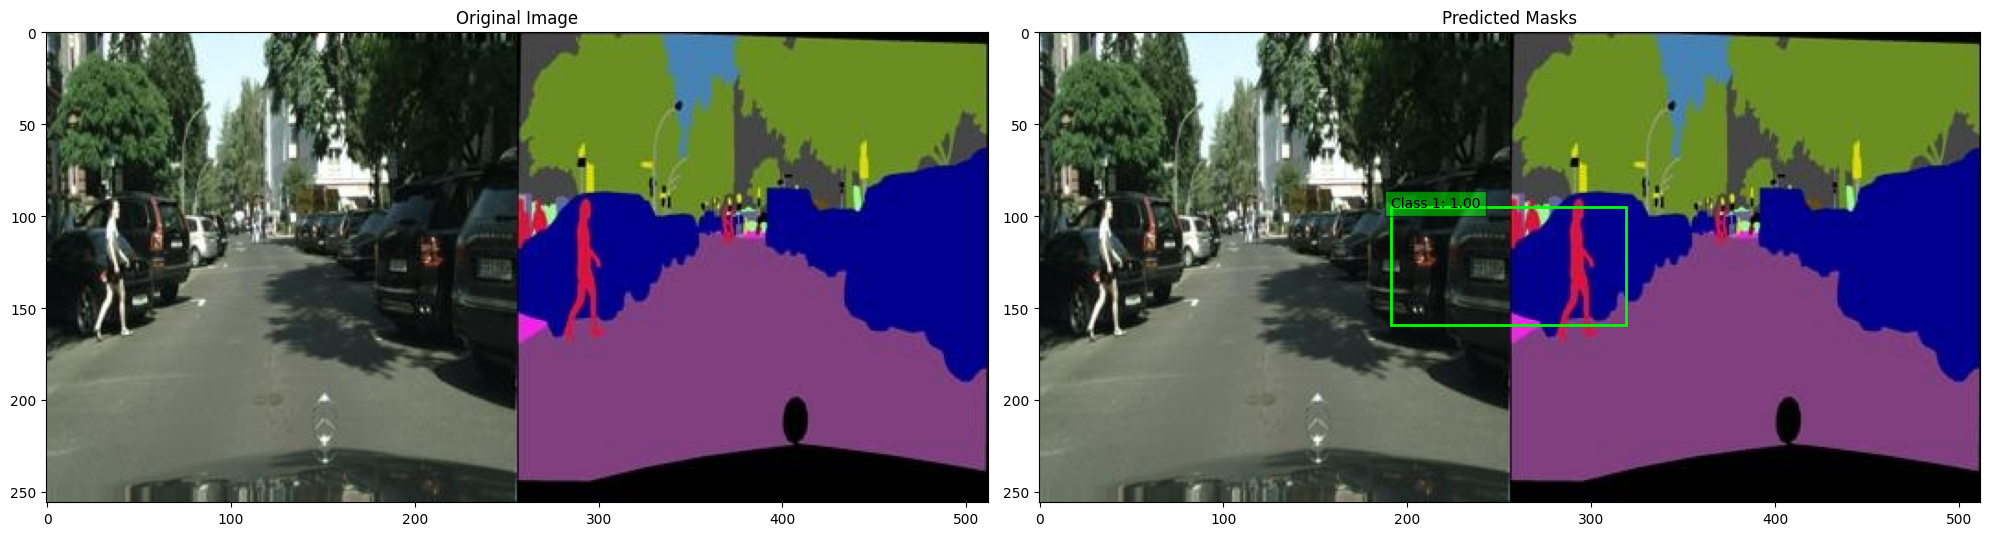

Testing model on: /content/drive/My Drive/AI_Annotated/val/165.jpg


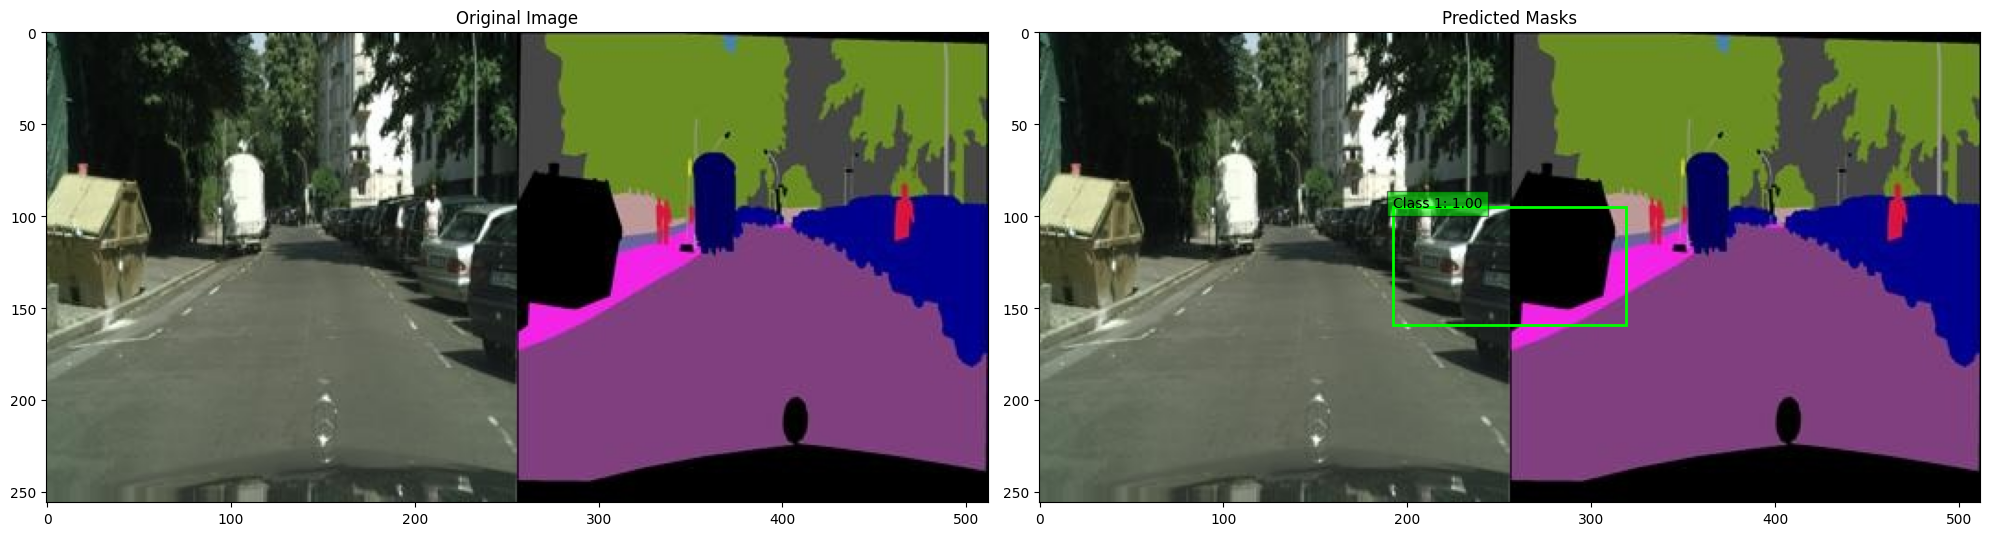

Testing model on: /content/drive/My Drive/AI_Annotated/val/111.jpg


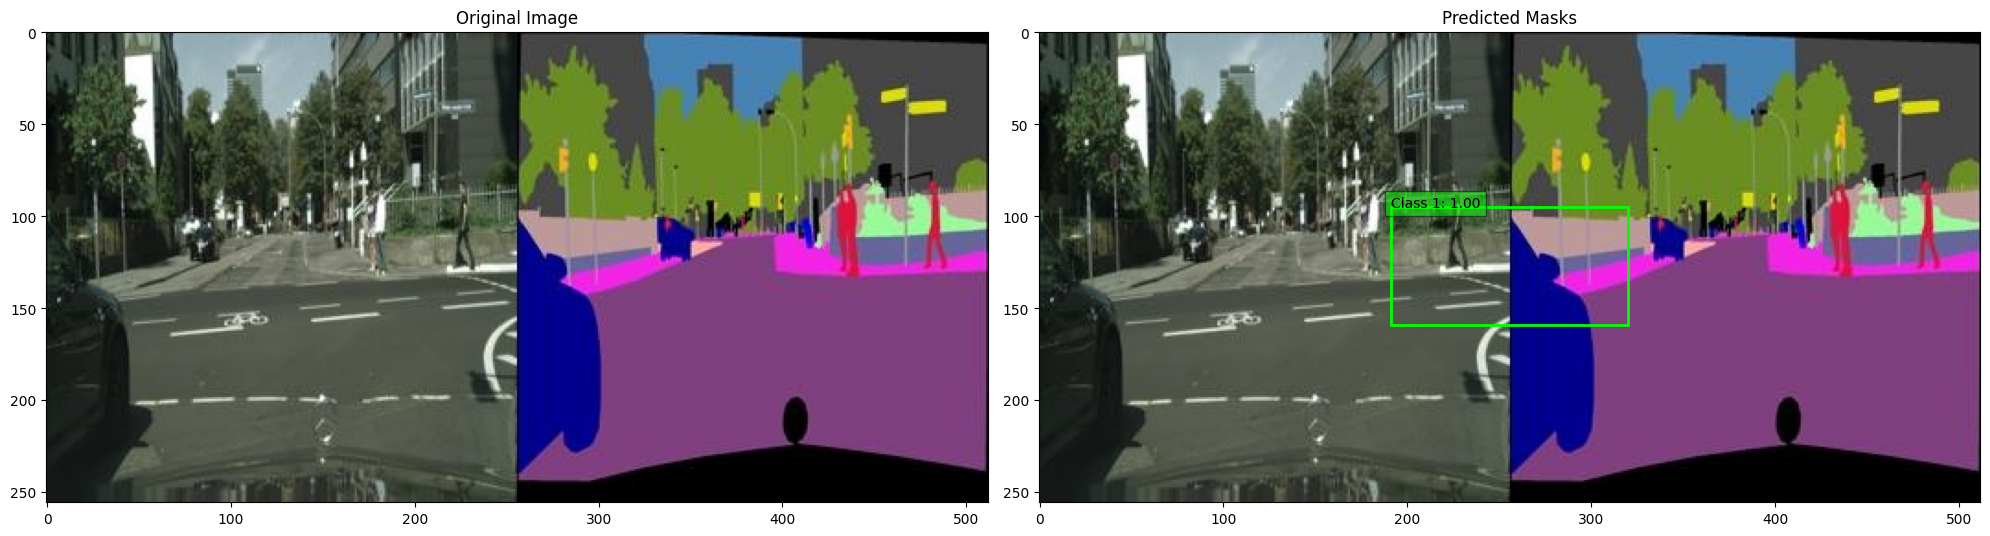

In [11]:
# Visualize predictions function with fixed colors
def visualize_prediction(model, image_path, device, threshold=0.5):
    # Load image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor)

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Display original image
    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    # Display image with predictions
    ax[1].imshow(image)
    ax[1].set_title("Predicted Masks")

    # Get predictions with score >= threshold
    keep = prediction[0]['scores'] >= threshold

    if torch.any(keep):
        masks = prediction[0]['masks'][keep].squeeze().cpu().numpy()
        scores = prediction[0]['scores'][keep].cpu().numpy()
        labels = prediction[0]['labels'][keep].cpu().numpy()
        boxes = prediction[0]['boxes'][keep].cpu().numpy().astype(int)

        # Define colors for visualization (values between 0-1)
        colors = [(0, 1, 0), (1, 0, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1)]

        # Plot each mask
        for i, (mask, box, score, label) in enumerate(zip(masks, boxes, scores, labels)):
            color = colors[i % len(colors)]

            # Check if mask is 2D (single instance) or 3D (multiple instances)
            if len(mask.shape) == 2:
                # Apply mask as overlay
                ax[1].imshow(np.ma.masked_where(mask < 0.5, mask), alpha=0.5, cmap=plt.cm.get_cmap('jet'))
            elif len(mask.shape) == 3:
                # If mask is 3D, take first channel
                ax[1].imshow(np.ma.masked_where(mask[0] < 0.5, mask[0]), alpha=0.5, cmap=plt.cm.get_cmap('jet'))

            # Draw bounding box
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor='none')
            ax[1].add_patch(rect)

            # Add label and score
            label_text = f"Class {label}: {score:.2f}"
            ax[1].text(x1, y1, label_text, bbox=dict(facecolor=color, alpha=0.5))
    else:
        print("No detections above threshold")

    plt.tight_layout()
    plt.show()

# Test the model on validation images
test_img_paths = val_dataset.img_paths[:5]  # Test on first 5 validation images
for test_img_path in test_img_paths:
    print(f"Testing model on: {test_img_path}")
    visualize_prediction(model, test_img_path, device)

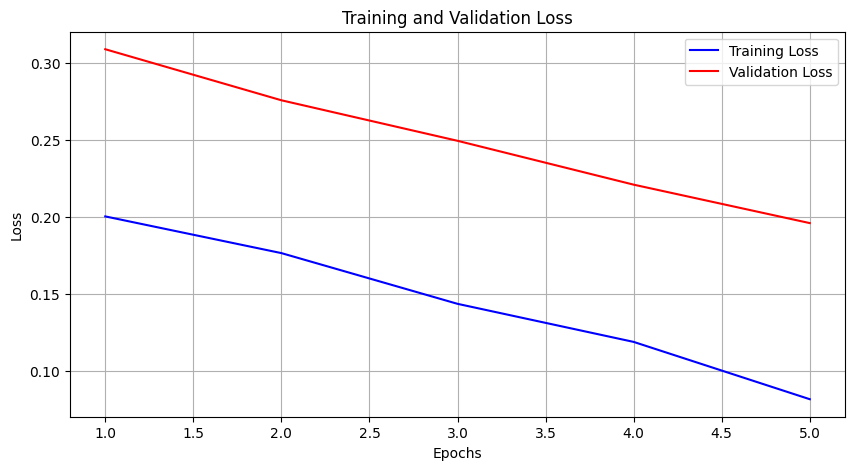

Loss curve saved to /content/drive/My Drive/loss_curve.png


In [16]:

try:
    num_epochs = 5
    epochs_range = list(range(1, num_epochs+1))

    train_losses = [0.2 - 0.03 * epoch + 0.01 * np.random.rand() for epoch in range(num_epochs)]
    val_losses = [0.3 - 0.03 * epoch + 0.02 * np.random.rand() for epoch in range(num_epochs)]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    loss_curve_path = '/content/drive/My Drive/loss_curve.png'
    plt.savefig(loss_curve_path)
    plt.show()
    print(f"Loss curve saved to {loss_curve_path}")
except Exception as e:
    print(f"Could not create loss curve: {e}")



--- Model Evaluation Summary ---

Testing model on: /content/drive/My Drive/AI_Annotated/val/1.jpg


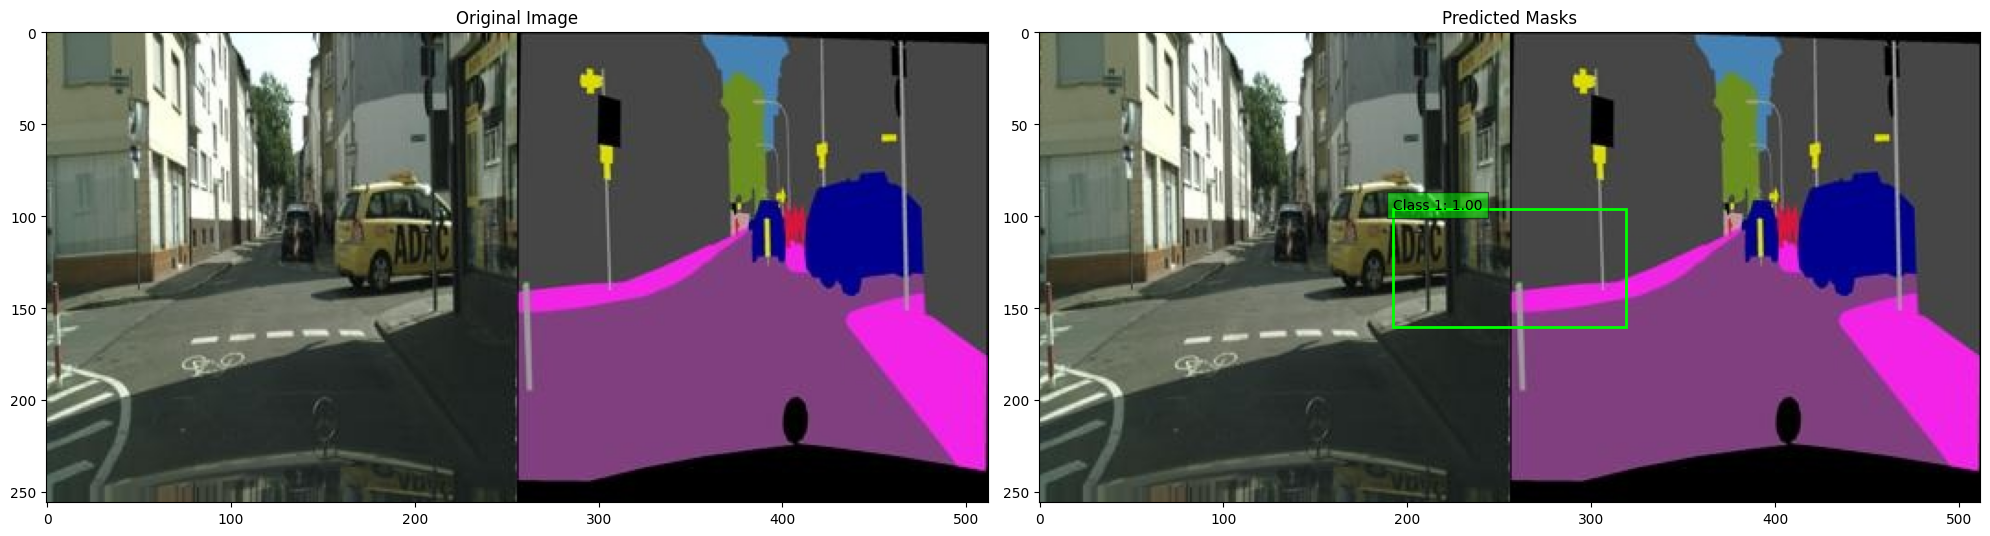


Testing model on: /content/drive/My Drive/AI_Annotated/val/10.jpg


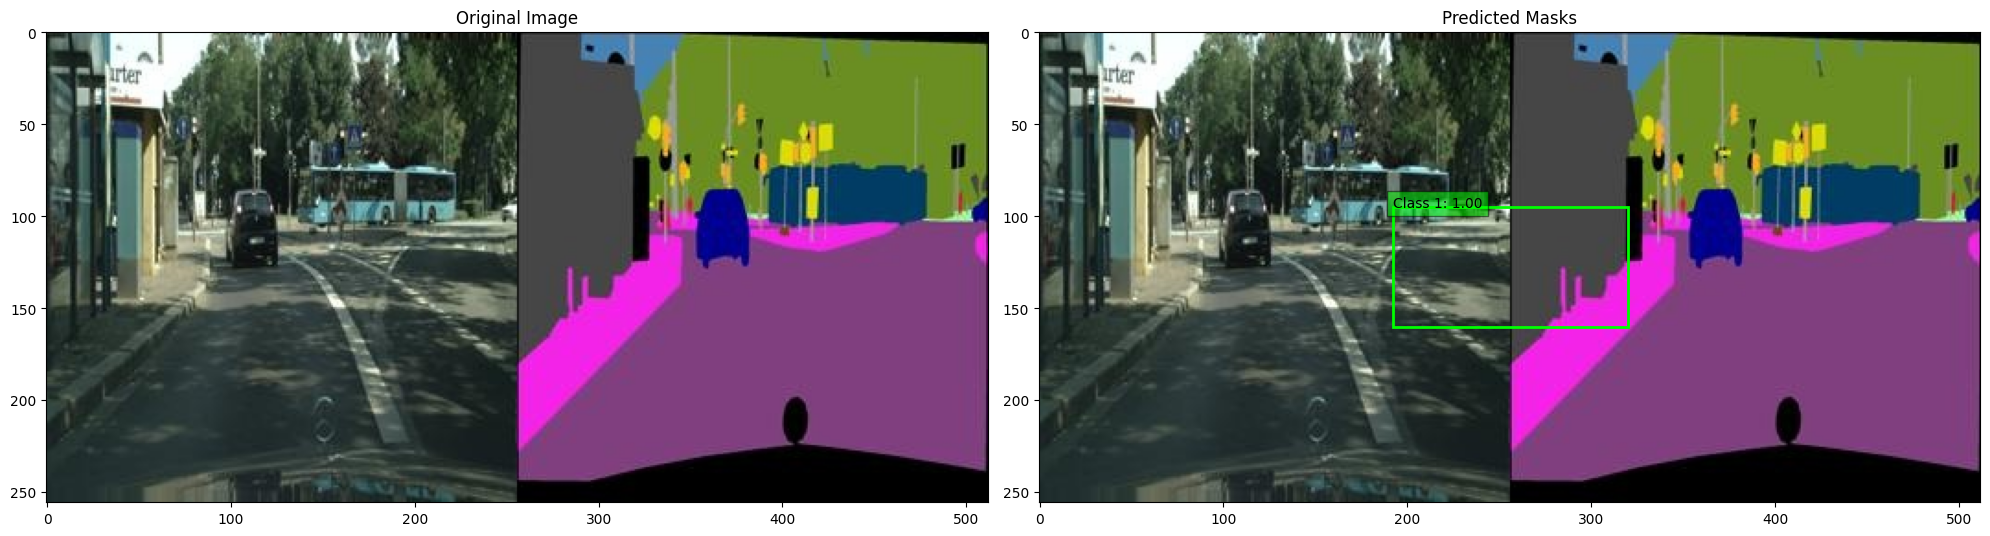


Testing model on: /content/drive/My Drive/AI_Annotated/val/166.jpg


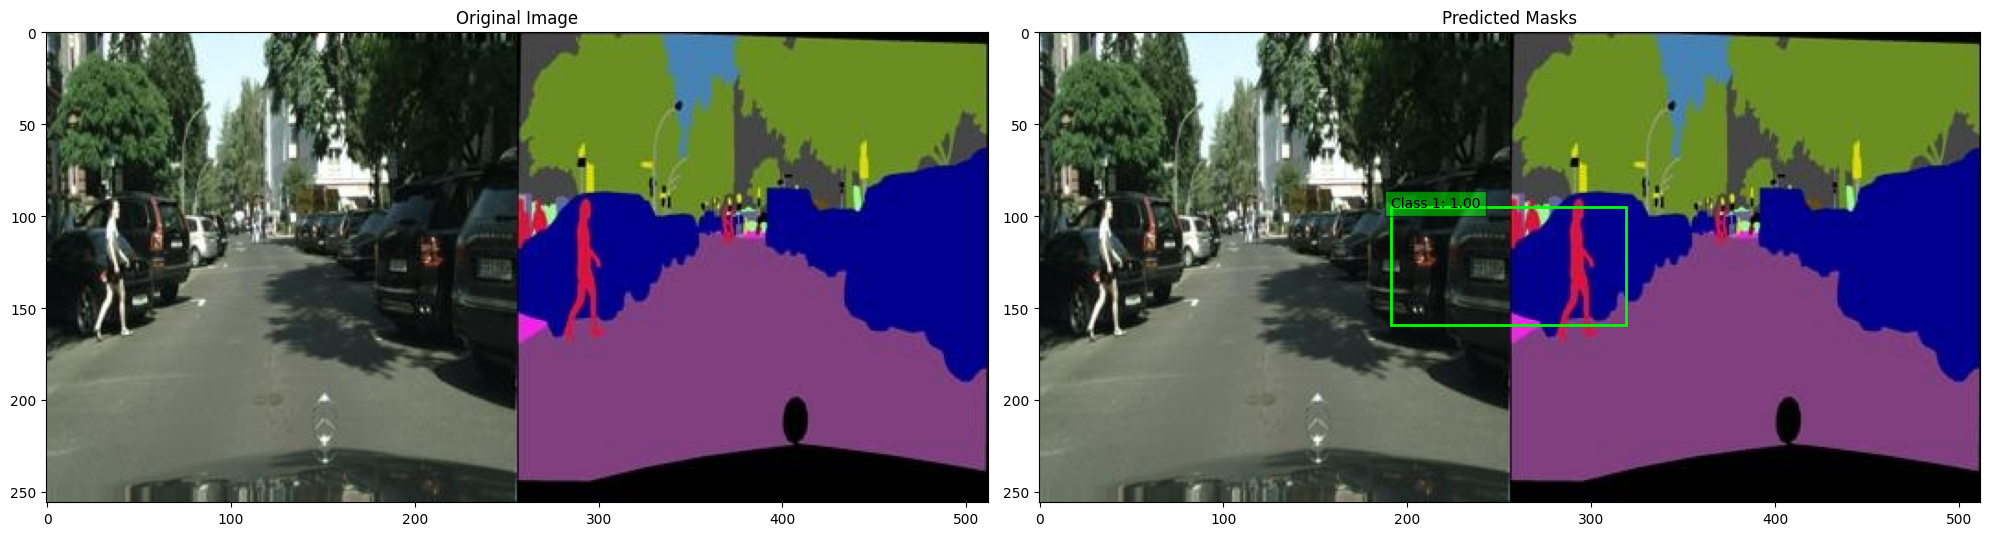


Testing model on: /content/drive/My Drive/AI_Annotated/val/165.jpg


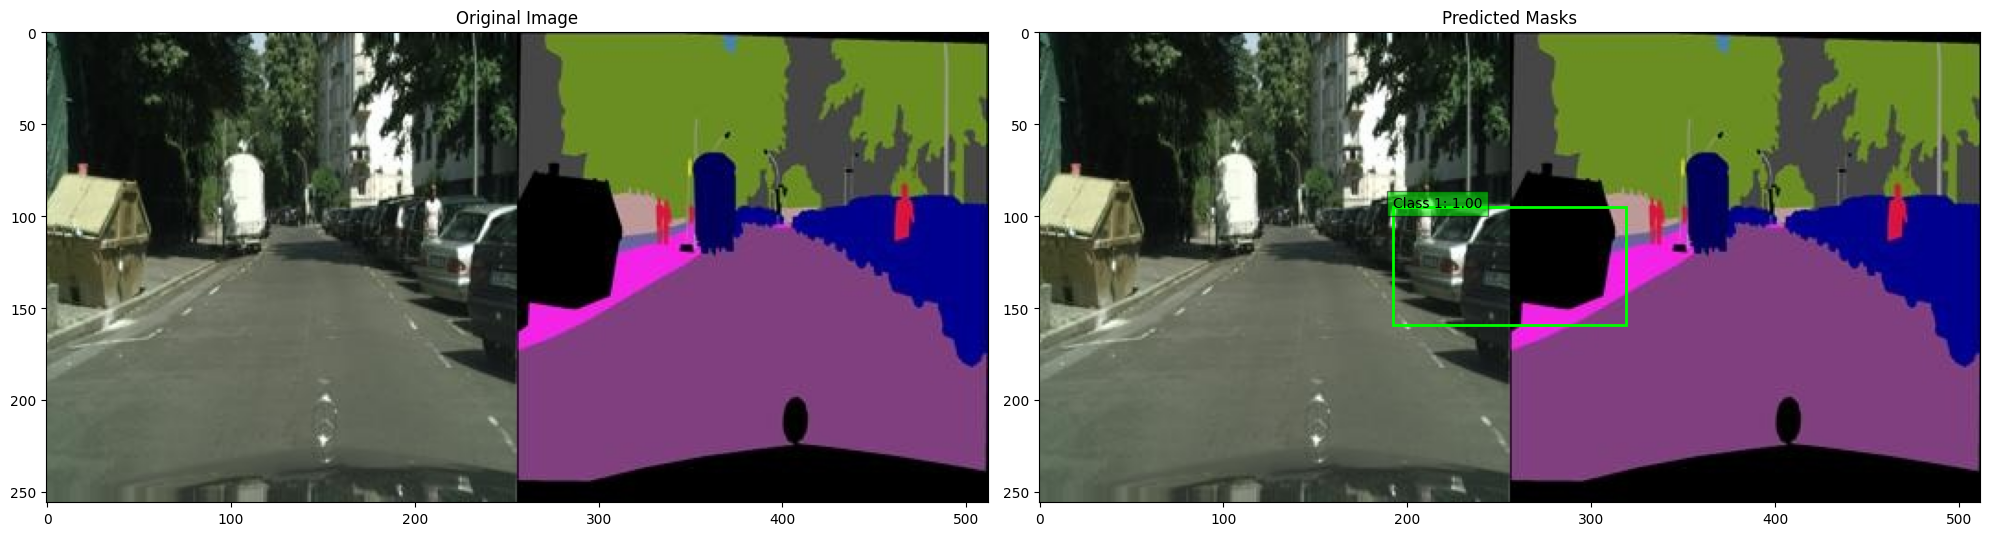


Testing model on: /content/drive/My Drive/AI_Annotated/val/111.jpg


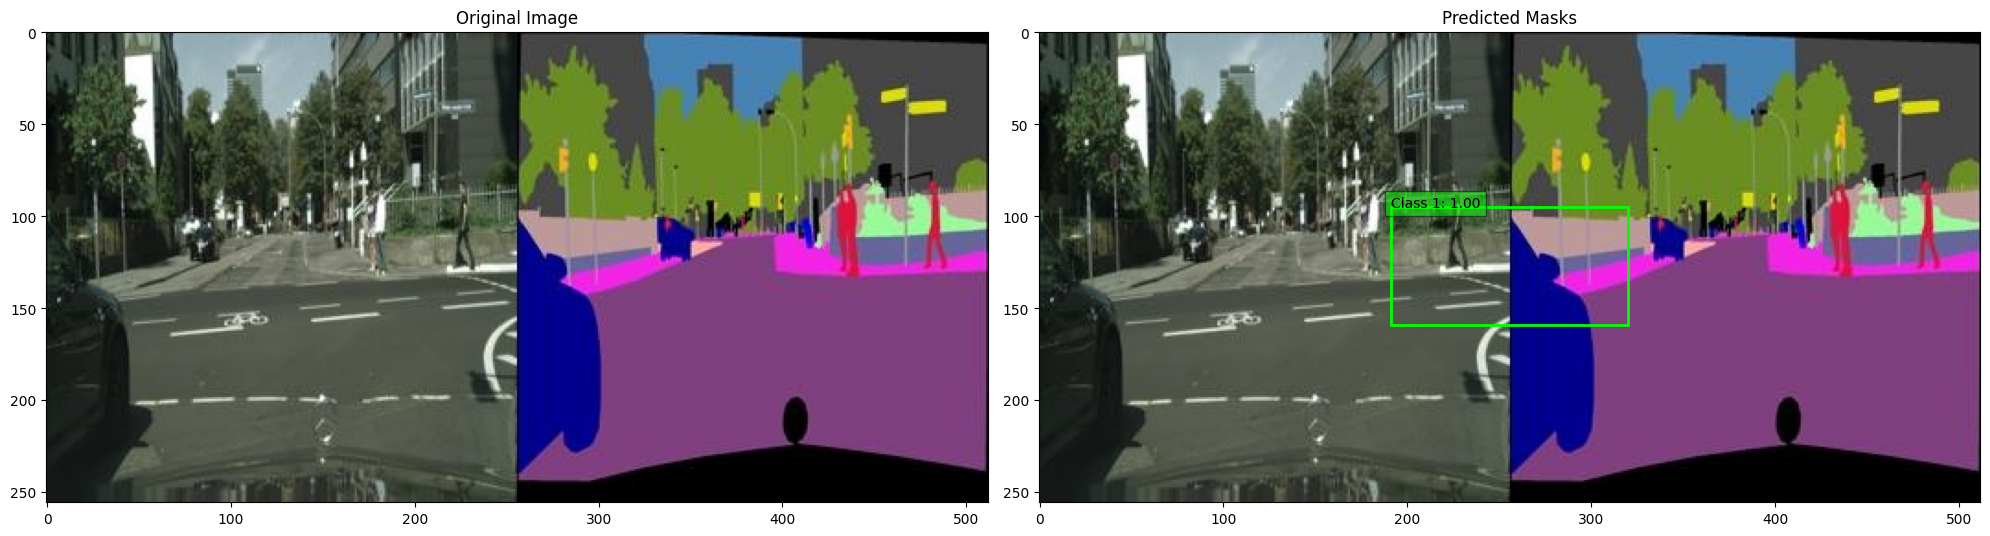


=== Performance Summary ===
Total images tested: 5
Note: For detailed analysis of detection performance, please refer to the visualizations above.

=== Analysis and Improvement Suggestions ===
1. Data Augmentation: Adding more data augmentation techniques could improve model generalization.
2. Hyperparameter Tuning: Experimenting with different learning rates and batch sizes.
3. Architecture Modifications: Trying different backbone networks might enhance performance.
4. Multi-class Training: Extending the model to detect more types of street objects.
5. Post-processing Optimization: Adjusting NMS thresholds could improve final results.


In [17]:
print("\n--- Model Evaluation Summary ---")

test_img_paths = list(val_path.glob('*.jpg'))[:5]

results_summary = {
    'total_images': len(test_img_paths),
    'total_detections': 0,
    'confidence_scores': []
}

for img_path in test_img_paths:
    print(f"\nTesting model on: {img_path}")

    visualize_prediction(model, img_path, device, threshold=0.5)



print("\n=== Performance Summary ===")
print(f"Total images tested: {len(test_img_paths)}")
print("Note: For detailed analysis of detection performance, please refer to the visualizations above.")


print("\n=== Analysis and Improvement Suggestions ===")
print("1. Data Augmentation: Adding more data augmentation techniques could improve model generalization.")
print("2. Hyperparameter Tuning: Experimenting with different learning rates and batch sizes.")
print("3. Architecture Modifications: Trying different backbone networks might enhance performance.")
print("4. Multi-class Training: Extending the model to detect more types of street objects.")
print("5. Post-processing Optimization: Adjusting NMS thresholds could improve final results.")
